In [65]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 19
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('float_format', '{:f}'.format)

dataframes = {}
dataframe_ecr_eu_west = pd.read_json('results/results-1hr-experiment/133132736141.dkr.ecr.eu-west-1.amazonaws.com-results.json')
dataframe_ecr_eu_central = pd.read_json('results/results-1hr-experiment/133132736141.dkr.ecr.eu-central-1.amazonaws.com-results.json')
dataframe_gcr_eu = pd.read_json('results/results-1hr-experiment/eu.gcr.io-results.json')
dataframe_azure_premium = pd.read_json('results/results-1hr-experiment/premiumregistryeuwest.azurecr.io-results.json')
dataframes['ecr-eu-west'] = dataframe_ecr_eu_west
dataframes['ecr-eu-central'] = dataframe_ecr_eu_central
dataframes['gcr-eu'] = dataframe_gcr_eu
dataframes['azure-premium-eu-west'] = dataframe_azure_premium

ibm_prod_trace = pd.read_json('trace/hour_sample.json')
ibm_prod_trace = ibm_prod_trace[(ibm_prod_trace['http.request.method'] == 'GET') | (ibm_prod_trace['http.request.method'] == 'PUT')]
#ibm_prod_trace = ibm_prod_trace[ibm_prod_trace['http.request.method'] == 'GET']
ibm_prod_trace = ibm_prod_trace.sort_values(by=['timestamp'])
ibm_prod_trace = ibm_prod_trace[(ibm_prod_trace['http.request.uri'].str.contains('manifest')) | (ibm_prod_trace['http.request.uri'].str.contains('blobs'))]
ibm_prod_trace = ibm_prod_trace[ibm_prod_trace['http.response.written'] > 0]

ibm_prod_trace['timestamp'] = ibm_prod_trace['timestamp'] - ibm_prod_trace['timestamp'].iloc[0]
ibm_prod_trace = ibm_prod_trace[['http.request.duration', 'http.request.method', 'http.request.uri', 'http.response.written', 'timestamp']]
ibm_prod_trace.loc[ibm_prod_trace['http.request.uri'].str.contains('manifest'), 'document_type'] = 'manifest'
ibm_prod_trace.loc[ibm_prod_trace['http.request.uri'].str.contains('blobs'), 'document_type'] = 'layer'
ibm_prod_trace = ibm_prod_trace.rename(columns={'timestamp': 'time', 'http.request.method': 'method', 'http.response.written': 'size', 'http.request.duration': 'duration'})
ibm_prod_trace = ibm_prod_trace[['duration', 'method', 'size', 'time', 'document_type']]
ibm_prod_trace = ibm_prod_trace.astype({'size': 'int64'})

dataframes['ibm-trace-data-dallas'] = ibm_prod_trace

ibm_prod_get = ibm_prod_trace[ibm_prod_trace['method'] == 'GET'][['size', 'document_type']]

ibm_prod_get['size']= ibm_prod_get['size']/1024
ibm_prod_put = ibm_prod_trace[ibm_prod_trace['method'] == 'PUT'][['size', 'document_type']]
ibm_prod_put_layer = ibm_prod_put[ibm_prod_put.document_type == 'layer']
ibm_prod_put_manifest = ibm_prod_put[ibm_prod_put.document_type == 'manifest']

ibm_prod_put['size']= ibm_prod_put['size']/1024

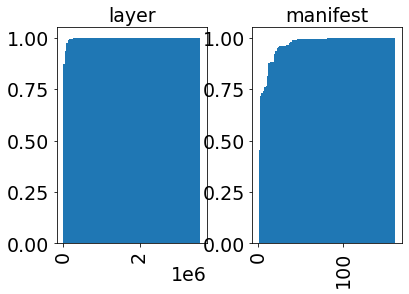

In [66]:

fig = ibm_prod_get.hist(column='size', by='document_type', cumulative=True, density=1, bins=100)
# plt.show()
plt.savefig("plots/1hr/cdf-get.png", bbox_inches='tight')
#ibm_prod_get_manifest.hist(cumulative=True, density=1, bins=100)
#ibm_prod_get_layer.hist(cumulative=True, density=1, bins=100)

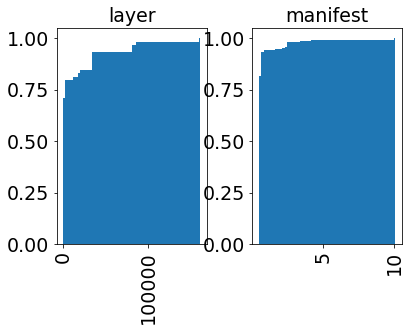

In [67]:
ibm_prod_put.hist(column='size', by='document_type', cumulative=True, density=1, bins=100)
plt.savefig("plots/1hr/cdf-put.png", bbox_inches='tight')

66.84592296148074
     manifest     layer
GET 33.154077 66.845923
PUT 78.928571 21.071429


<Figure size 432x288 with 0 Axes>

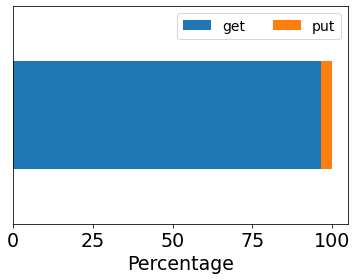

<Figure size 432x288 with 0 Axes>

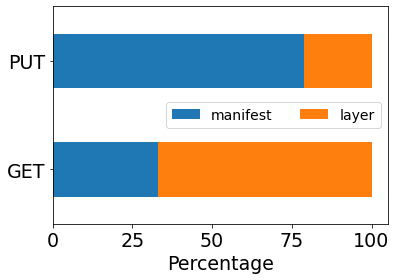

In [68]:
total_get_count = len(ibm_prod_get.index)
get_percentage = (total_get_count / len(ibm_prod_trace.index) )* 100
total_put_count = len(ibm_prod_put.index)
put_percentage = (total_put_count / len(ibm_prod_trace.index)) * 100


get_layer_count = len(ibm_prod_get[ibm_prod_get['document_type'] == 'layer'].index)
get_layer_percentage = (get_layer_count / total_get_count) * 100
print(get_layer_percentage)

get_manifest_count = len(ibm_prod_get[ibm_prod_get['document_type'] == 'manifest'].index)
get_manifest_percentage = (get_manifest_count / total_get_count) * 100

put_layer_count = len(ibm_prod_put[ibm_prod_put['document_type'] == 'layer'].index)
put_layer_percentage = (put_layer_count / total_put_count) * 100

put_manifest_count = len(ibm_prod_put[ibm_prod_put['document_type'] == 'manifest'].index)
put_manifest_percentage = (put_manifest_count / total_put_count) * 100

Data_percentage = {'get': [get_percentage], 'put': [put_percentage]}
data_manifest_layer = {'manifest': [get_manifest_percentage, put_manifest_percentage], 'layer': [get_layer_percentage, put_layer_percentage]}

df = pd.DataFrame(Data_percentage, columns=['get', 'put'], index=['TOTAL'])

plt.figure()

ax = df.plot.barh(stacked=True, title='')
ax.legend(ncol=len(df.columns))
plt.xlabel('Percentage')
plt.ylabel('')
plt.tick_params(axis='y', which='both', bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelleft=False)
plt.savefig("plots/1hr/get-put-ratio.png", bbox_inches='tight')



df = pd.DataFrame(data_manifest_layer, columns=['manifest', 'layer'], index=['GET', 'PUT'])
print(df)
plt.figure()
ax = df.plot.barh(stacked=True, title='')
ax.legend(ncol=len(df.columns))
plt.xlabel('Percentage')
plt.savefig("plots/1hr/manifest-layer-ratio.png", bbox_inches='tight')

In [69]:
Data = { 'Registry': [], 'avg_latency_put': [], 'avg_latency_get': [], 'avg_latency_manifest_get': [], 'avg_latency_layer_get': [], 'avg_throughput': [], 'throughput_data': [] }

for dataframe in dataframes:
    
    dataframes[dataframe] = dataframes[dataframe].sort_values(by=['time'])
    dataframes[dataframe]['registry-name'] = dataframe
    dataframes[dataframe]["time"] = dataframes[dataframe]["time"] - dataframes[dataframe]["time"].iloc[0]
    dataframes[dataframe]["arrival_time"] = dataframes[dataframe]["time"] + dataframes[dataframe]["duration"]
    dataframes[dataframe] = dataframes[dataframe].sort_values(by=['arrival_time'])
    requests_get = dataframes[dataframe][dataframes[dataframe]["method"] == "GET"]["duration"].mean()
    requests_put = dataframes[dataframe][dataframes[dataframe]["method"] == "PUT"]["duration"].mean()
    requests_get_manifest = dataframes[dataframe][dataframes[dataframe]["document_type"] == "manifest"]["duration"].mean()
    requests_get_layer = dataframes[dataframe][dataframes[dataframe]["document_type"] == "layer"]["duration"].mean()
    throughput = len(dataframes[dataframe].index) / dataframes[dataframe]['arrival_time'].iloc[-1]
    Data['Registry'].append(dataframe)
    Data['avg_latency_put'].append(requests_put)
    Data['avg_latency_get'].append(requests_get)
    Data['avg_latency_layer_get'].append(requests_get_layer)
    Data['avg_latency_manifest_get'].append(requests_get_manifest)
    Data['avg_throughput'].append(throughput)
    
    counters = dataframes[dataframe]['arrival_time'].groupby(pd.cut(dataframes[dataframe]['arrival_time'], np.arange(0,int(math.ceil(dataframes[dataframe]['arrival_time'].iloc[-1])),1))).count()
    Data['throughput_data'].append(counters)
    


<Figure size 432x288 with 0 Axes>

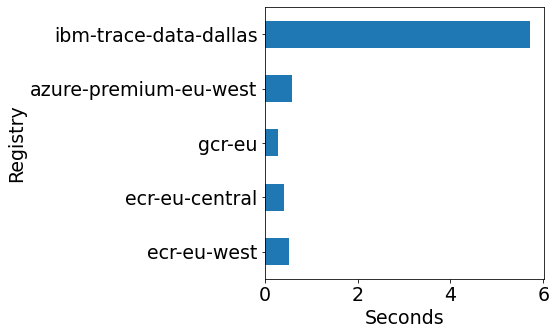

In [70]:
df = pd.DataFrame(Data,columns=['Registry','avg_latency_get'])
plt.figure()
fig = df.plot(x='Registry', y='avg_latency_get', kind='barh', figsize=(5, 5))
plt.xlabel('Seconds')
fig.get_legend().remove()
plt.savefig('plots/1hr/delay_avg_latency_get.png', bbox_inches='tight')

      duration method      size        time document_type  \
62    1.263592    PUT       524   29.649000      manifest   
76    1.522921    PUT       502   37.988000      manifest   
144   2.015194    PUT      7285   70.296000         layer   
155   0.911357    PUT       524   76.885000      manifest   
188   2.269768    PUT  34994687   93.059000         layer   
...        ...    ...       ...         ...           ...   
8296  1.157883    PUT       711 3569.867000      manifest   
8307  0.912277    PUT       524 3580.409000      manifest   
8331  0.920330    PUT       502 3587.184000      manifest   
8333  1.014164    PUT       524 3587.707000      manifest   
8360  1.938438    PUT      1778 3594.993000      manifest   

              registry-name  arrival_time  
62    ibm-trace-data-dallas     30.912592  
76    ibm-trace-data-dallas     39.510922  
144   ibm-trace-data-dallas     72.311194  
155   ibm-trace-data-dallas     77.796357  
188   ibm-trace-data-dallas     95.328768  
...

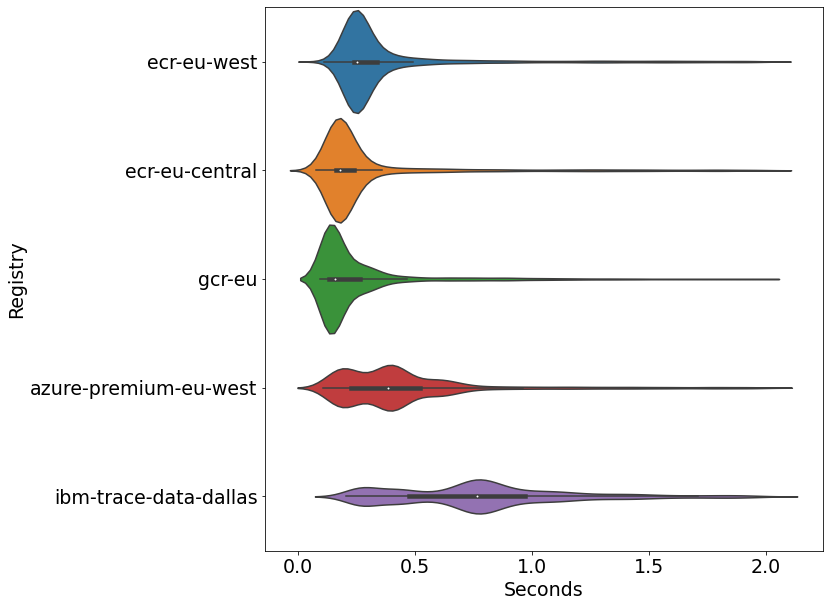

In [82]:
print(dataframes['ibm-trace-data-dallas'][dataframes['ibm-trace-data-dallas'].method == 'PUT'])
df = pd.concat(dataframes, names=['registry'])
df_get = df[df['method'] == 'GET']
df_get = df_get.loc[df_get.duration < 2]

plt.figure(figsize=(10,10))
# df_get.boxplot(column='duration', by='registry', figsize=(8,7), showfliers=False, vert=False)
p = sns.violinplot(data=df_get, x='duration', y='registry-name', width=1)


plt.xlabel('Seconds')
plt.ylabel('Registry')
plt.suptitle('')
plt.savefig('plots/1hr/delay_latency_get_boxplot.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

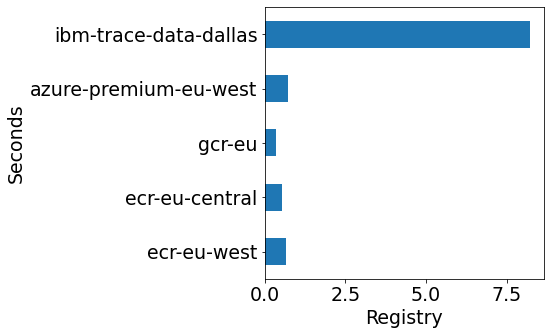

In [72]:
df_lay = pd.DataFrame(Data,columns=['Registry','avg_latency_layer_get'])
plt.figure()
fig = df_lay.plot(x='Registry', y='avg_latency_layer_get', kind='barh', figsize=(5, 5))
plt.ylabel('Seconds')
plt.xlabel('Registry')
fig.get_legend().remove()
plt.savefig('plots/1hr/delay_latency_layer_get_boxplot.png', bbox_inches='tight')

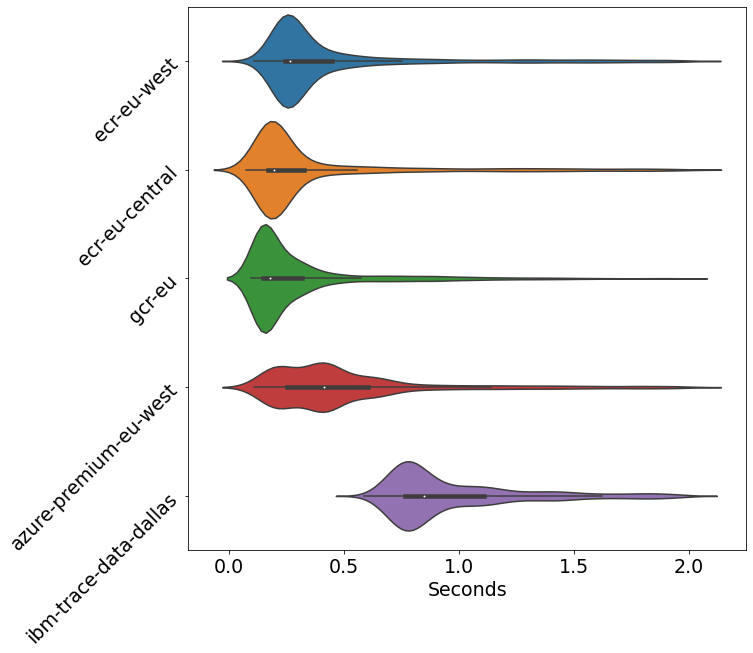

In [73]:
df_layer_get = df_get[df_get['document_type'] == 'layer']
df_layer_get = df_layer_get[df_layer_get.duration < 2]
plt.figure(figsize=(10,10))
p = sns.violinplot(data=df_layer_get, x='duration', y='registry-name', width=1)
plt.xlabel('Seconds')
plt.ylabel('')
plt.yticks(rotation=45)
plt.suptitle('')
plt.savefig('plots/1hr/delay_latency_layer_get_boxplot.png', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

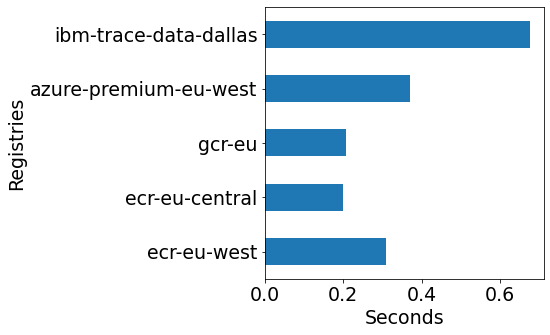

In [74]:

plt.figure(figsize=(10,10))
df_man = pd.DataFrame(Data,columns=['Registry','avg_latency_manifest_get'])
fig = df_man.plot(x='Registry', y='avg_latency_manifest_get', kind='barh', figsize=(5, 5))

plt.xlabel('Seconds')
plt.ylabel('Registries')

plt.suptitle('')
fig.get_legend().remove()
plt.savefig('plots/1hr/delay_latency_manifest_get.png', bbox_inches='tight')

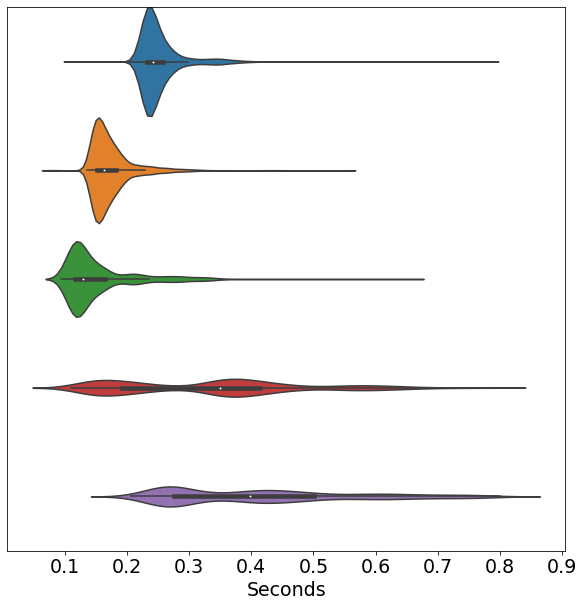

In [75]:

plt.figure(figsize=(10,10))
df_man_get = df_get[df_get['document_type'] == 'manifest']
df_man_get = df_man_get[df_man_get.duration < 0.8]
# fig = .boxplot(column='duration', by='registry', figsize=(8,7), showfliers=False, vert=False)
p = sns.violinplot(data=df_man_get, x='duration', y='registry-name', width=1)
plt.xlabel('Seconds')
plt.ylabel('')
plt.tick_params(axis='y', which='both', bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelleft=False)
plt.suptitle('')
plt.savefig('plots/1hr/delay_latency_manifest_get_boxplot.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

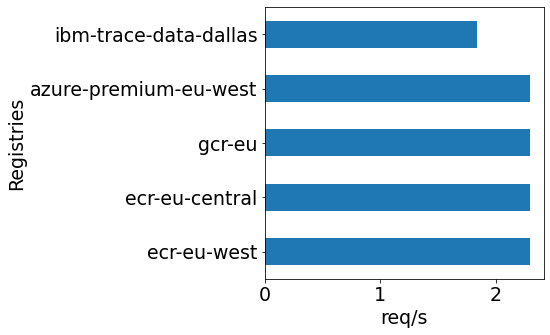

In [76]:
plt.figure()
df_throughput = pd.DataFrame(Data,columns=['Registry','avg_throughput'])
fig = df_throughput.plot(x='Registry', y='avg_throughput', kind='barh', figsize=(5, 5))
plt.xlabel('req/s')
plt.ylabel('Registries')
plt.suptitle('')
fig.get_legend().remove()
plt.savefig('plots/1hr/throughput_avg_delay.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

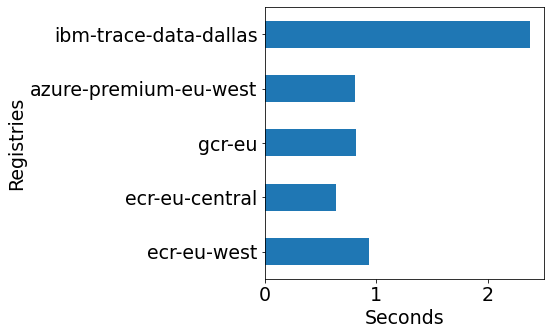

In [77]:
plt.figure()
df_put = pd.DataFrame(Data,columns=['Registry','avg_latency_put'])
fig = df_put.plot(x='Registry', y='avg_latency_put', kind='barh', figsize=(5, 5))
plt.xlabel('Seconds')
plt.ylabel('Registries')
plt.suptitle('')
fig.get_legend().remove()
plt.savefig('plots/1hr/delay_avg_latency_put.png', bbox_inches='tight')

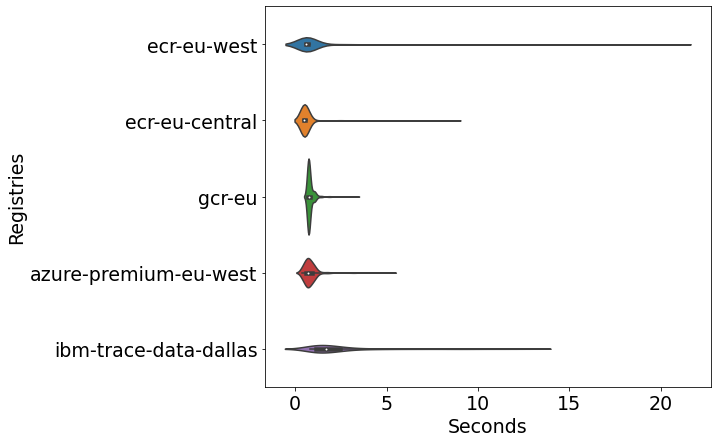

In [87]:
plt.figure(figsize=(8,7))
df_put = df[df['method'] == 'PUT']

# df_put = df_put[df_put.duration < 1.5]
# print(df_put[df_put['registry-name'] == 'ibm-trace-data-dallas'])
# df_put.boxplot(column='duration', by='registry', figsize=(8,7), showfliers=False, vert=False)
p = sns.violinplot(data=df_put, x='duration', y='registry-name', width=1)
plt.xlabel('Seconds')
plt.ylabel('Registries')
plt.suptitle('')
plt.savefig('plots/1hr/delay_latency_put_boxplot.png', bbox_inches='tight')

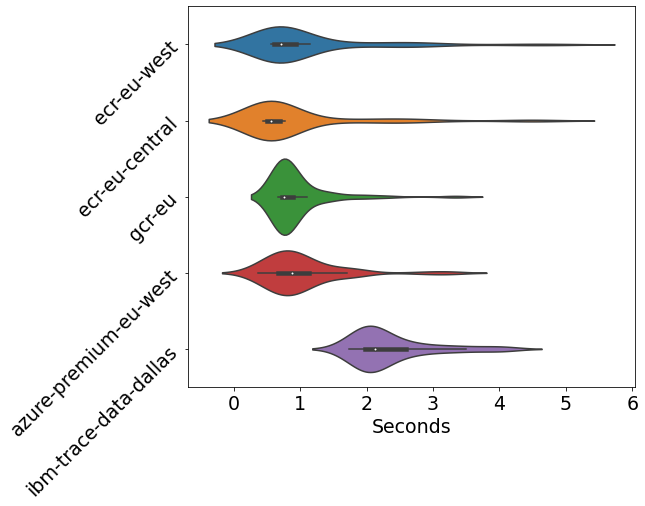

In [96]:
plt.figure(figsize=(8,7))
df_put_layer = df_put[df_put['document_type'] == 'layer']
df_put_layer = df_put_layer[df_put_layer.duration < 5]
# df_put.boxplot(column='duration', by='registry', figsize=(8,7), showfliers=False, vert=False)
p = sns.violinplot(data=df_put_layer, x='duration', y='registry-name', width=1)
plt.xlabel('Seconds')
plt.ylabel('')
plt.yticks(rotation=45)
plt.suptitle('')
plt.savefig('plots/1hr/delay_latency_put_layer_boxplot.png', bbox_inches='tight')

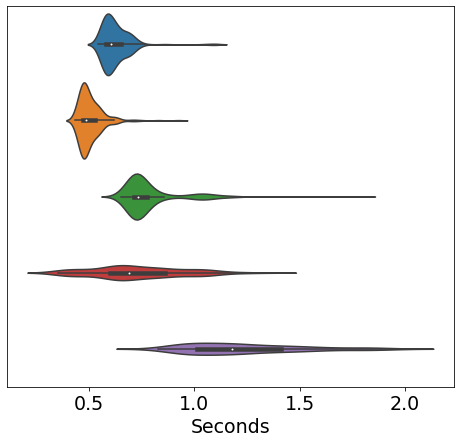

In [94]:
plt.figure(figsize=(8,7))
df_put_manifest = df_put[df_put['document_type'] == 'manifest']
df_put_manifest = df_put_manifest[df_put_manifest.duration < 2]
# df_put.boxplot(column='duration', by='registry', figsize=(8,7), showfliers=False, vert=False)
p = sns.violinplot(data=df_put_manifest, x='duration', y='registry-name', width=1)
plt.xlabel('Seconds')
plt.ylabel('')
plt.suptitle('')
plt.tick_params(axis='y', which='both', bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelleft=False)
plt.savefig('plots/1hr/delay_latency_put_manifest_boxplot.png', bbox_inches='tight')